## Shear estimation bias experiments

This is a notebook that runs a few shape measurement experiements to demonstrate some
common shear estimation biases: e.g. noise bias, model bias 
We use the package GalSim (https://galsim-developers.github.io/GalSim/_build/html/index.html#)
which is a useful tool for generating galaxy image simulations (and was partly developed for 
community shear estimation challenges like GREAT03 https://arxiv.org/abs/1308.4982 that invited 
cosmologists and computer scientists to test out their approaches on blind data.

In [1]:
import galsim
import numpy as np
import matplotlib
import pylab
import os
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt

Initialize some simple galaxy profile using GalSim

In [2]:
#input galaxy params
gal_flux = 1.e5
gal_sigma = 1.
input_e1 = 0.1
input_e2 = 0.
pixel_scale=0.2

#some simple input galaxy model
gal = galsim.Gaussian(flux=gal_flux, sigma=gal_sigma)
gal = gal.shear(g1=input_e1, g2=input_e2)

draw this to an image, and plot

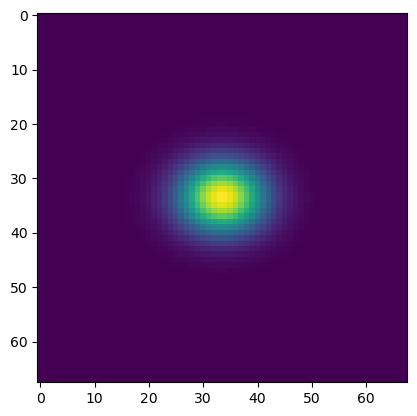

In [3]:
%matplotlib inline
#galaxy image

fig,ax=plt.subplots()
gal_im = gal.drawImage(scale=pixel_scale)
ax.imshow(gal_im.array)

## Measure the ellipticity

Use quadrupole moments:

First find centroid:
$[\bar{x_1},\bar{x_2}] = \frac{\int \mathrm{d}^2{x} I(x_1,x_2) [x_1,x_2]}{\int  \mathrm{d}^2{x} I(x_1,x_2)} $

Then compute quadrupole moments (c.f. variance = 2nd moment of PDF):
$Q_{ij} =  \frac{\int \mathrm{d}^2{x} I(x_1,x_2)[x_i-\bar{x_i},x_j-\bar{x_j}]}{\int  \mathrm{d}^2{x} I(x_1,y_2)}$

Now define ellipticity:
$e_1 = \frac{Q_{11} - Q_{22}}{Q_{11} + Q_{22} + 2( Q_{11}Q_{22} - Q_{12}^2 )^{1/2} }$, $e_2 = \frac{Q_{12}}{Q_{11} + Q_{22} + 2(Q_{11}Q_{22}-Q_{12}^2)^{1/2}}$

(e1 = how extended in x vs. y, e2 = how extended along x=y vs. x=-y)

In [4]:
def get_centroid(gal_im):
    X,Y = np.meshgrid(np.arange(gal_im.shape[0]), np.arange(gal_im.shape[1]))
    denom = np.sum(gal_im)
    return (np.sum(gal_im*X)/denom, np.sum(gal_im*Y)/denom)

def get_second_moments(gal_im):
    X,Y = np.meshgrid(np.arange(gal_im.shape[0]), np.arange(gal_im.shape[1]))
    xbar,ybar = get_centroid(gal_im)
    denom = np.sum(gal_im)
    Qxx = np.sum( gal_im * (X-xbar)**2 )
    Qyy = np.sum( gal_im * (Y-ybar)**2 )
    Qxy = np.sum( gal_im * (X-xbar) * (Y-ybar) )
    return Qxx, Qyy, Qxy

def get_shear(gal_im):
    Qxx, Qyy, Qxy = get_second_moments(gal_im)
    e1_num = (Qxx - Qyy)
    e2_num = 2*Qxy
    denom = Qxx + Qyy + 2*np.sqrt(Qxx*Qyy - Qxy**2)
    return (e1_num/denom, e2_num/denom)

## Run on our sample image

In [5]:
print("e1, e2 =", get_shear(gal_im.array))

e1, e2 = (0.09966773955245661, -8.552438867074685e-08)


Great, we got out what we put in...
Now what about if we have noise? 
Let's assume simple Gaussian noise...what does our galaxy look like now?

In [6]:
rng=galsim.BaseDeviate(1234) #initialize some rng 
noise_sigma=15

galsim.Image(bounds=galsim.BoundsI(1,68,1,68), scale=0.2, dtype=numpy.float32)


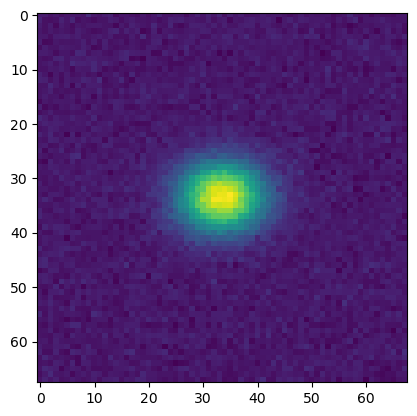

In [7]:
%matplotlib inline
gal_im = gal.drawImage(scale=pixel_scale)
gal_im.addNoise(galsim.GaussianNoise(rng, sigma=noise_sigma))
print(gal_im)
fig,ax=plt.subplots()
ax.imshow(gal_im.array)

Measure it's shape again...

In [8]:
print("e1, e2 =", get_shear(gal_im.array))

e1, e2 = (0.40006082229588336, 0.09454462507674823)


Is it just noisy or also biased? Run on a load of noise realisations...

In [9]:
num_realisations = 1000
e1_and_e2s = np.zeros((num_realisations, 2))
for i in range(num_realisations):
    if i%100==0:
        print("done %d realisations"%i)
    gal_im = gal.drawImage(scale=pixel_scale)
    gal_im.addNoise(galsim.GaussianNoise(rng, sigma=noise_sigma))
    e1,e2 = get_shear(gal_im.array)
    e1_and_e2s[i] = np.array([e1,e2])

print("mean e1, e2 =", e1_and_e2s.mean(axis=0))

done 0 realisations
done 100 realisations
done 200 realisations
done 300 realisations
done 400 realisations
done 500 realisations
done 600 realisations
done 700 realisations
done 800 realisations
done 900 realisations
mean e1, e2 = [ 0.10513492 -0.00081536]


In [10]:
def plot_e1_hist(ax, e1s):
    ax.hist(e1s, density=True, color='k', histtype='step')
    mean_e1 = e1s.mean()
    mean_e1_err = np.std(e1s)/np.sqrt(len(e1s))
    ylim=ax.get_ylim()
    ax.plot([mean_e1,mean_e1], ylim, color='C0')
    ax.fill_betweenx(ylim, mean_e1-2*mean_e1_err, mean_e1+2*mean_e1_err, color='C0', alpha=0.25)
    ax.set_ylim(ylim)

bias in e1, e2 = [ 0.00513492 -0.00081536]
fractional bias in e1 = 5.13%


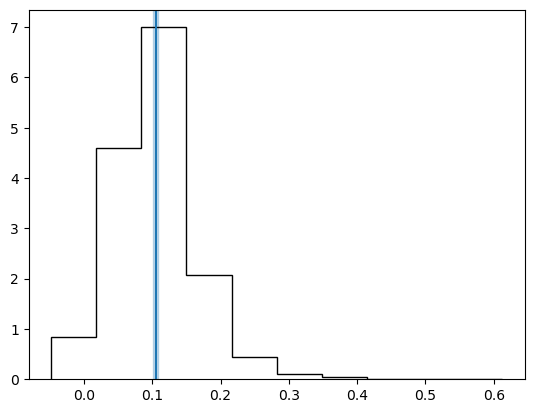

In [11]:
%matplotlib inline

fig,ax=plt.subplots()

plot_e1_hist(ax, e1_and_e2s[:,0])
print("bias in e1, e2 =", e1_and_e2s.mean(axis=0) - np.array([input_e1, input_e2]))
print("fractional bias in e1 = %.2f%%"%(100*(e1_and_e2s[:,0].mean() - input_e1)/input_e1))

Why is the estimator biased?

Because of the noise: **Noise bias**
Any estimator that is a non-linear function of noisy data will suffer from this. 
E.g. we have a model y = m*x, both y and x are noisy. Is y/x an unbiased estimator for x?
The estimator is even more problematic when we have noisier data:

In [12]:
noise_sigma=150
num_realisations = 1000
e1_and_e2s = np.zeros((num_realisations, 2))
for i in range(num_realisations):
    if i%100==0:
        print("done %d realisations"%i)
    gal_im = gal.drawImage(scale=pixel_scale)
    gal_im.addNoise(galsim.GaussianNoise(rng, sigma=noise_sigma))
    e1,e2 = get_shear(gal_im.array)
    e1_and_e2s[i] = np.array([e1,e2])
print("mean e1, e2 =", e1_and_e2s.mean(axis=0))

done 0 realisations
done 100 realisations
done 200 realisations
done 300 realisations
done 400 realisations


/var/folders/z8/dfsq32cd3x76jkqr3qqvfqqh0000gn/T/ipykernel_60455/1661882208.py:19: RuntimeWarning: invalid value encountered in sqrt
  denom = Qxx + Qyy + 2*np.sqrt(Qxx*Qyy - Qxy**2)


done 500 realisations
done 600 realisations
done 700 realisations
done 800 realisations
done 900 realisations
mean e1, e2 = [nan nan]


## What has happened here?
## This estimator can diverge for noisy data! 

## We can use a weight function $W(x_1,x_2)$ in our moments calculations to make things more stable:

## $Q_{ij} =  \frac{\int \mathrm{d}^2{x} W(x_1,x_2) I(x_1,x_2)[x_i-\bar{x_i},x_j-\bar{x_j}]}{\int  \mathrm{d}^2{x} W(x_1,x_2) I(x_1,y_2)}$

## Choose $W$ to upweight pixels where $S/N$ is high e.g. let's try a circular Gaussian with $\sigma$ equal to the size of the galaxy
## We can use the same get_shear function as before, but passing the weighted galaxy image, W * gal_im instead

In [13]:
W = galsim.Gaussian(sigma=gal_sigma)

num_realisations = 1000
e1_and_e2s = np.zeros((num_realisations, 2))
for i in range(num_realisations):
    if i%100==0:
        print("done %d realisations"%i)
    gal_im = gal.drawImage(scale=pixel_scale)
    weight_im = W.drawImage(scale=pixel_scale, bounds=gal_im.bounds)
    gal_im.addNoise(galsim.GaussianNoise(rng, sigma=noise_sigma))
    e1,e2 = get_shear(weight_im.array * gal_im.array)
    e1_and_e2s[i] = np.array([e1,e2])

print("mean e1, e2 =", e1_and_e2s.mean(axis=0))
print("bias in e1, e2=", e1_and_e2s.mean(axis=0) - np.array([input_e1, input_e2]))
print("fractional bias in e1=", (e1_and_e2s[:,0].mean() - input_e1)/input_e1)

done 0 realisations
done 100 realisations
done 200 realisations
done 300 realisations
done 400 realisations
done 500 realisations
done 600 realisations
done 700 realisations
done 800 realisations
done 900 realisations
mean e1, e2 = [4.99868395e-02 8.42915692e-05]
bias in e1, e2= [-5.00131605e-02  8.42915692e-05]
fractional bias in e1= -0.5001316051903026


In [14]:
## Ok now we get something that converges...but it is biased. Why?
## Because we've used a circular weight function! 
W_elliptical = galsim.Gaussian(sigma=gal_sigma)
W_elliptical = W_elliptical.shear(e1=input_e1,e2=input_e2)

num_realisations opll= 100
e1_and_e2s = np.zeros((num_realisations, 2))
for i in range(num_realisations):
    if i%100==0:
        print("done %d realisations"%i)
    gal_im = gal.drawImage(scale=pixel_scale)
    weight_im = W_elliptical.drawImage(scale=pixel_scale, bounds=gal_im.bounds)
    gal_im.addNoise(galsim.GaussianNoise(rng, sigma=0.0001))
    e1,e2 = get_shear(weight_im.array * gal_im.array)
    e1_and_e2s[i] = np.array([e1,e2])

print("mean e1, e2 =", e1_and_e2s.mean(axis=0))
print("bias in e1, e2=", e1_and_e2s.mean(axis=0) - np.array([input_e1, input_e2]))
print("fractional bias in e1 = %.2f%%"%(100*(e1_and_e2s[:,0].mean() - input_e1)/input_e1))

done 0 realisations
mean e1, e2 = [7.48588194e-02 4.03972628e-09]
bias in e1, e2= [-2.51411806e-02  4.03972628e-09]
fractional bias in e1 = -25.14%


Estimator converges again, but now it is biased. Why? 

Because we used a circular weight function (we're now measuring the shape of W * gal_im). If we don't want to use a weight function, how else can we beat this noise bias? 